In [2]:
import pandas as pd
train = pd.read_csv('./train.csv')

From the EDA notebook we noticed that one of the most popular check in place_id is 7230349735.
With x coordinate in range(7.3,9.4) and y coordinate in range(8.16,8.21). In this note we run some ml algorithms on this area as an experiment.

In [8]:
small_area = train[(train.x.between(8.2,8.6,inclusive=True)) & (train.y.between(8.16,8.21,inclusive=True))]

In [9]:
small_area.shape

(6584, 6)

In [45]:
small_area.head()

,row_id,x,y,accuracy,time,place_id
3058,3058,8.2079,8.2055,817,175790,4049860263
18455,18455,8.2356,8.1853,58,706769,9770375030
30269,30269,8.3546,8.1977,57,735910,4304822810
30338,30338,8.5358,8.1778,69,387904,6414214152
37861,37861,8.3126,8.1866,61,426850,4049860263


In [10]:
# filter out place_id with few checkins
# pick the top 10 popular ones
top_place_count = small_area.groupby('place_id').count().sort_values('row_id', ascending = False)[:10]
top_place_id = top_place_count.index 
filtered = small_area[small_area.place_id.isin(top_place_id)]

# Compute the number of checkins in these popular places as column 'frequency'
top_place_count['place_id'] = top_place_count.index
top_place_count = top_place_count.drop(['x','y','accuracy', 'time'], axis = 1)
top_place_count = top_place_count.rename(columns={'row_id': 'frequency'})

# Add the column 'frequency' into the dataframe: filtered

filtered = filtered.merge(top_place_count, on = 'place_id').sort_values(by ='frequency', ascending = False)
filtered.head()

,row_id,x,y,accuracy,time,place_id,frequency
0,3058,8.2079,8.2055,817,175790,4049860263,898
675,21462497,8.3056,8.1883,34,446990,4049860263,898
592,19094952,8.2982,8.1871,432,679663,4049860263,898
593,19115748,8.3368,8.1947,7,144558,4049860263,898
594,19117648,8.2953,8.1957,132,696008,4049860263,898


Now we have selected top 10 popular check in places in this neighborhood, lets see the distribution of them.

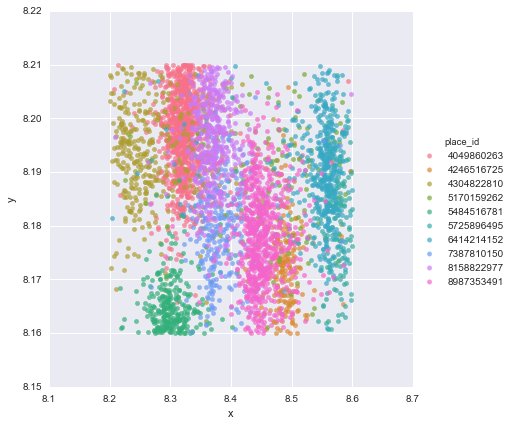

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

g = sns.FacetGrid(filtered, hue="place_id", size=6)
g.map(plt.scatter, 'x','y', alpha = 0.7 )
g.add_legend()
plt.savefig('./popular_area.png')

We see a very intersting pattern here, the clusters of each place_id are of vertical shapes. A natural question is if it is a general phenomenon. To answer this question, we try another random area.


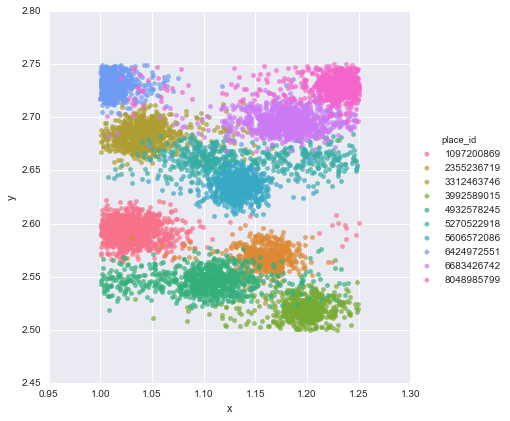

In [5]:
#x >1, x <1.25, y >2.5, y < 2.75
small_area2 = train[(train.x.between(1,1.25,inclusive=True)) & (train.y.between(2.5,2.75,inclusive=True))]
top_place_count = small_area2.groupby('place_id').count().sort_values('row_id', ascending = False)[:10]
top_place_id = top_place_count.index 
filtered = small_area2[small_area2.place_id.isin(top_place_id)]

g = sns.FacetGrid(filtered, hue="place_id", size=6)
g.map(plt.scatter, 'x','y', alpha = 0.7 )
g.add_legend()

So the vertical pattern may not be universal. Lets take a look of 
### The distribution of check in  time over the locations

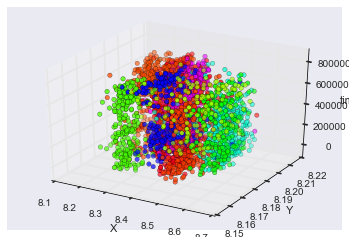

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(filtered.x, filtered.y, filtered.time, marker='o',c = filtered.place_id, cmap=plt.cm.hsv )




ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('time')

#plt.show()

There are some clusters in this picture, which make sense because some business may open just during lunch and dinner time. To understand it better, we need to translate the numerical time representation into an understandable form.

In [17]:
filtered['hour'] = (filtered.time/60) %24
filtered['day'] = (filtered.time/(60*24)) %7
filtered.hour = filtered.hour.apply(lambda x: int(round(x)) %24)
filtered.day = filtered.day.apply(lambda x: int(round(x)) %7)

In [244]:
filtered.head()

,row_id,x,y,accuracy,time,place_id,frequency,hour,day
0,3058,8.2079,8.2055,817,175790,4049860263,898,2,3
675,21462497,8.3056,8.1883,34,446990,4049860263,898,10,2
592,19094952,8.2982,8.1871,432,679663,4049860263,898,0,3
593,19115748,8.3368,8.1947,7,144558,4049860263,898,9,2
594,19117648,8.2953,8.1957,132,696008,4049860263,898,8,0


If we plot 'early' time and 'late' time separatly, we can see some business only operates on eraly time, for example, red and purple points. Others operates more on late time, for example the blue points.

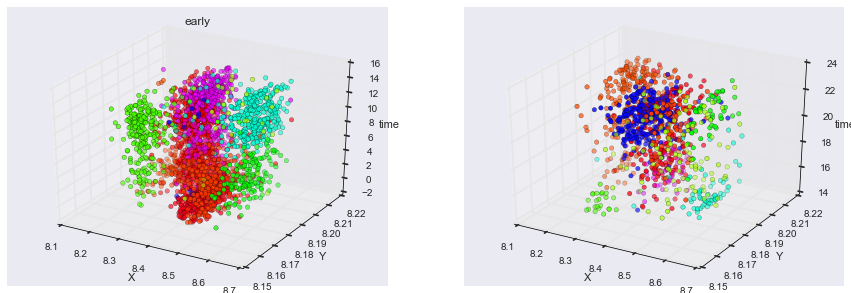

In [18]:
early = filtered[filtered.hour<=14]
late = filtered[filtered.hour > 14]

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax = fig.add_subplot(1,2,1, projection='3d')


ax.scatter(early.x, early.y, early.hour, marker='o',c = early.place_id, cmap=plt.cm.hsv )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('time')
ax.set_title('early')

ax = fig.add_subplot(1,2,2, projection='3d')


ax.scatter(late.x, late.y, late.hour, marker='o',c = late.place_id, cmap=plt.cm.hsv )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('time')

plt.savefig('./early_late.png')

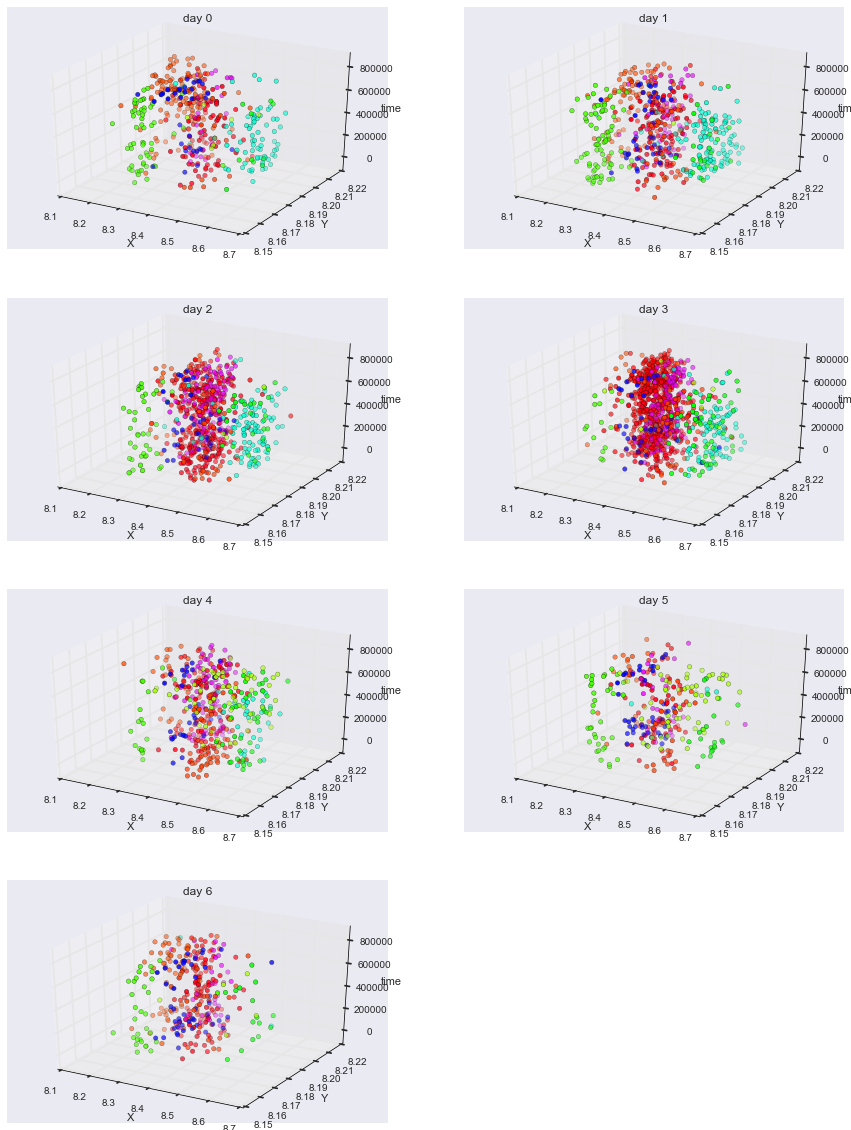

In [265]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(15)

for i in range(7):
    day_filtered = filtered[filtered.day == i]
    ax = fig.add_subplot(4,2,i+1, projection='3d')
    ax.scatter(day_filtered.x, day_filtered.y, day_filtered.time, marker='o',c = day_filtered.place_id, cmap=plt.cm.hsv )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('time')
    ax.set_title('day %d' %i)

### KNN
We run knn on the small area we selected before. Since knn computes distance between points, which is dominated by features with large values. So we first take normalization of accuracy. Second, we noticed that there are lot of place_id with only 1 or 2 checkins. These rare place_id's may affect the prediction, so we train another model using only higher frequency. It turns out that the accuracy is improved.

In [269]:
# We see that accuracy and time have larger values than x and y
filtered.head()

,row_id,x,y,accuracy,time,place_id,frequency,hour,day
0,3058,8.2079,8.2055,817,175790,4049860263,898,2,3
675,21462497,8.3056,8.1883,34,446990,4049860263,898,10,2
592,19094952,8.2982,8.1871,432,679663,4049860263,898,0,3
593,19115748,8.3368,8.1947,7,144558,4049860263,898,9,2
594,19117648,8.2953,8.1957,132,696008,4049860263,898,8,0


In [272]:
# Normalize  accuracy

acc_mean = np.mean(filtered.accuracy)
acc_std = np.std(filtered.accuracy)

normal_filtered = filtered

normal_filtered.accuracy = normal_filtered.accuracy.apply(lambda x: (x-acc_mean)/acc_std)

In [273]:
# The result after normalization
normal_filtered.head()

,row_id,x,y,accuracy,time,place_id,frequency,hour,day
0,3058,8.2079,8.2055,7.532648,175790,4049860263,898,2,3
675,21462497,8.3056,8.1883,-0.511369,446990,4049860263,898,10,2
592,19094952,8.2982,8.1871,3.577416,679663,4049860263,898,0,3
593,19115748,8.3368,8.1947,-0.788749,144558,4049860263,898,9,2
594,19117648,8.2953,8.1957,0.495418,696008,4049860263,898,8,0


In [281]:
# splitting data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    normal_filtered[['x','y','accuracy','hour','day']], normal_filtered['place_id'], test_size=0.33, random_state=1024)

In [297]:
# using all data points, even with very few checkins
from sklearn.neighbors import KNeighborsClassifier

# Try different k
possible_k = [1,2,3,4,5,10,15,20]

result = []
for k in possible_k:
    knn = KNeighborsClassifier(n_neighbors=k)

    # fitting the model
    knn.fit(X_train, y_train)

    # training model prediction
    in_pred = knn.predict(X_train)

    # predict the response
    pred = knn.predict(X_test)

    # evaluate test accuracy
    result.append([k,np.sum([pred == y_test])/float(len(pred))])



In [298]:
# It turn out 1-NN gives the best result. But note that we only used 
# the most frequent check in data.

result

[[1, 0.63461538461538458],
 [2, 0.58769230769230774],
 [3, 0.60384615384615381],
 [4, 0.5938461538461538],
 [5, 0.59846153846153849],
 [10, 0.57076923076923081],
 [15, 0.55846153846153845],
 [20, 0.57076923076923081]]

### Try training on data set with low frequency place_id dropped out

In [319]:
# Using only points with higher numer of checkins
#with_frequency = normal_filtered.groupby('place_id').count()
#with_frequency['place_id'] = with_frequency.index
#with_frequency = with_frequency.drop(['time','x','y','accuracy'], axis = 1)
#with_frequency = with_frequency.rename(columns={'row_id': 'frequency'})
#normal_filtered= normal_filtered.merge(with_frequency, on = 'place_id')
droped_X_train['y'] = y_train
with_frequency = dropped_normal_filtered.groupby('place_id').count()

#dropped_normal_filtered = normal_filtered[normal_filtered.frequency > 0]

In [312]:
possible_k = [1,2,3,4,5,10,15,20]

result = []
for k in possible_k:
    knn = KNeighborsClassifier(n_neighbors=k)


    # fitting the model
    model = knn.fit(dropped_normal_filtered[['x','y','accuracy','hour','day']] , dropped_normal_filtered['place_id'])

    # predict the response
    pred = model.predict(X_test)


    
    result.append([k,np.sum([pred == y_test])/float(len(pred))])

In [313]:
result

[[1, 1.0],
 [2, 0.83999999999999997],
 [3, 0.79692307692307696],
 [4, 0.76846153846153842],
 [5, 0.74230769230769234],
 [10, 0.68000000000000005],
 [15, 0.64538461538461533],
 [20, 0.59923076923076923]]